# Pharmaceutical Economic Data Hub – Data Loading & Visualization

This notebook reads **only** from these four data sources:

| # | Data source | What it is | Access method |
|---|-------------|------------|----------------|
| **1** | **NADAC** (National Average Drug Acquisition Cost) | Medicaid national average drug acquisition cost; used for pricing / reimbursement. | **File download** (CSV/Excel) from Medicaid.gov / data.medicaid.gov. Some portals expose a Socrata SODA API. |
| **2** | **FDA Orange Book** (Approved Drug Products with Therapeutic Equivalence Evaluations) | Approved small-molecule drugs and therapeutic equivalence (e.g. AB ratings); used for generic substitution. | **File download**: one **zip** from FDA (`fda.gov/media/76860/download`) containing **products.txt**, **patent.txt**, **exclusivity.txt** (pipe-delimited). |
| **3** | **FDA Purple Book** (Licensed Biological Products) | Licensed biologics, biosimilars, interchangeability; used for biologic substitution. | **File download**: **.csv** (or .xlsx) from FDA Purple Book data files page. |
| **4** | **OpenFDA** | FDA’s public API for drug labels, NDC, adverse events, etc. | **API only** (REST at api.fda.gov). No single bulk file; query endpoints and cache responses. |

- **Which is which:** In code we use `nadac`, `orange_book`, `purple_book`, and `openfda` for these four sources.
- **Download vs API:** NADAC, Orange Book, and Purple Book are loaded from files (downloaded once if not already in `pharma_data/`). OpenFDA is accessed via the API; we cache the response to a local JSON file so we don’t re-call the API every run.

In [280]:
# Install third-party libraries if not already installed
import subprocess
import sys

def install_if_missing(package, import_name=None):
    """Install package via pip if import fails."""
    name = import_name or package
    try:
        __import__(name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_if_missing("pandas")
install_if_missing("requests")
install_if_missing("matplotlib")
install_if_missing("seaborn")
install_if_missing("openpyxl")  # for Excel files

print("Dependencies ready.")

Dependencies ready.


In [281]:
import os
import pandas as pd
import requests
from pathlib import Path

# ============== Configuration ==============
DATA_DIR = Path("pharma_data")  # local folder for downloaded files
DATA_DIR.mkdir(exist_ok=True)

# --------------- 1) NADAC (National Average Drug Acquisition Cost) ---------------
# File download: CSV/Excel from data.medicaid.gov; URL is set below.
NADAC_DOWNLOAD_URL = "https://download.medicaid.gov/data/nadac-national-average-drug-acquisition-cost-01-28-2026.csv"

# --------------- 2) FDA Orange Book (Approved Drug Products) ---------------
# Single zip from FDA; contains products.txt, patent.txt, exclusivity.txt (pipe-delimited)
FDA_ORANGE_BOOK_ZIP_URL = "https://www.fda.gov/media/76860/download"

# --------------- 3) FDA Purple Book (Biological Products) ---------------
# File download: .csv (or .xlsx) from FDA Purple Book; URL is set below.
FDA_PURPLE_BOOK_DOWNLOAD_URL = "https://purplebooksearch.fda.gov/files/2025/purplebook-search-december-data-download.csv"

# --------------- 4) OpenFDA (API only) ---------------
# No download URL; we call the API and cache the response.
# API key: https://open.fda.gov/apis/authentication/ (pass as api_key query param)
OPENFDA_BASE_URL = "https://api.fda.gov"
OPENFDA_API_KEY = os.environ.get("OPENFDA_API_KEY", "y5Ul5sCqN68pYWcULusZjiNXJP3eczaYbithSRPt")
OPENFDA_DRUG_LABELS_URL = f"{OPENFDA_BASE_URL}/drug/label.json"  # singular "label" per openFDA docs
OPENFDA_NDC_URL = f"{OPENFDA_BASE_URL}/drug/ndc.json"
OPENFDA_LIMIT = 100  # max results per request (API limit is 100)

In [282]:
def ensure_file(url, local_path, session=None):
    """
    Use local file if it exists; otherwise download from url.
    Returns path to the file (local_path), or None if no URL and file missing.
    """
    local_path = Path(local_path)
    if local_path.exists():
        print(f"Using existing file: {local_path}")
        return str(local_path)
    if not url or not url.strip():
        print(f"No URL provided for {local_path.name}. Place file at: {local_path.absolute()}")
        return None
    print(f"Downloading from {url} ...")
    try:
        r = (session or requests).get(url, timeout=60, stream=True)
        r.raise_for_status()
        with open(local_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Saved to {local_path}")
        return str(local_path)
    except Exception as e:
        print(f"Download failed: {e}")
        return None

def load_csv_or_excel(path, **read_kwargs):
    """Load DataFrame from CSV or Excel."""
    path = Path(path)
    if not path.exists():
        return None
    suf = path.suffix.lower()
    if suf == ".csv":
        return pd.read_csv(path, **read_kwargs)
    if suf in (".xlsx", ".xls"):
        return pd.read_excel(path, **read_kwargs)
    return pd.read_csv(path, **read_kwargs)

def load_pipe_delimited(path, sep="|", **read_kwargs):
    """Load pipe-delimited .txt (e.g. FDA Orange Book). Default sep is |."""
    path = Path(path)
    if not path.exists():
        return None
    return pd.read_csv(path, sep=sep, encoding="utf-8", on_bad_lines="skip", **read_kwargs)

def load_purple_book(path):
    """
    Load FDA Purple Book CSV. File structure:
    - Lines 1-3: title/metadata (skipped).
    - Line 4: column headers (N/R/U, Applicant, BLA Number, ...).
    - Lines 5-35: data for N (New) and U (Updated) products.
    - Line 36: empty row; line 37: duplicate header row.
    - Lines 38+: data for R (Products Added in Current Release); N/R/U column often empty.
    """
    path = Path(path)
    if not path.exists():
        return None
    if path.suffix.lower() != ".csv":
        return load_csv_or_excel(path)
    df = pd.read_csv(path, header=3)
    col0 = df.columns[0] if len(df.columns) > 0 else None
    if col0 is not None:
        df = df.loc[df.iloc[:, 0].astype(str).str.strip() != "N/R/U"]
    df = df.dropna(how="all")
    if col0 is not None and col0 == "N/R/U":
        df[col0] = df[col0].fillna("R").astype(str).str.strip()
        df.loc[df[col0] == "", col0] = "R"
    return df.reset_index(drop=True)

def _file_in_dir_or_subdir(base_dir, filename):
    """True if filename exists in base_dir or in any one level subdir."""
    base_dir = Path(base_dir)
    if not base_dir.exists():
        return False
    if (base_dir / filename).exists():
        return True
    for sub in base_dir.iterdir():
        if sub.is_dir() and (sub / filename).exists():
            return True
    return False

def ensure_zip_download_and_extract(url, zip_path, extract_dir, required_files=None):
    """
    If extract_dir already contains the required files (or in a subdir), use them and skip download.
    Otherwise download zip (with a browser-like User-Agent so FDA does not block) and extract.
    required_files: list of filenames that must exist (e.g. ["products.txt", "patent.txt", "exclusivity.txt"]).
    Returns extract_dir path if success, None otherwise.
    """
    import zipfile
    extract_dir = Path(extract_dir)
    zip_path = Path(zip_path)
    required_files = required_files or []

    def _has_all_files():
        return required_files and all(_file_in_dir_or_subdir(extract_dir, f) for f in required_files)

    if _has_all_files():
        print(f"Using existing extracted files in {extract_dir}")
        return str(extract_dir)

    if not url or not url.strip():
        print(f"No URL for zip. Place the zip at {zip_path} or extract {required_files} into {extract_dir}")
        return None

    extract_dir.mkdir(parents=True, exist_ok=True)
    if not zip_path.exists():
        print(f"Downloading zip from {url} ...")
        try:
            session = requests.Session()
            session.headers.update({
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0",
                "Accept": "application/zip, */*",
            })
            r = session.get(url, timeout=120, stream=True, allow_redirects=True)
            r.raise_for_status()
            with open(zip_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Saved to {zip_path}")
        except Exception as e:
            print(f"Download failed: {e}")
            if _has_all_files():
                print(f"Using existing extracted files in {extract_dir}")
                return str(extract_dir)
            print(f"If the download failed, place the zip at {zip_path} or extract {required_files} into {extract_dir}")
            return None

    if not zip_path.exists():
        return None
    print(f"Extracting {zip_path} to {extract_dir} ...")
    try:
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_dir)
        print(f"Extracted to {extract_dir}")
        return str(extract_dir)
    except Exception as e:
        print(f"Extract failed: {e}")
        return None

def fetch_openfda_and_cache(api_url, cache_path, limit=100, params=None, api_key=None):
    """
    Fetch OpenFDA API; use cached JSON if file exists, else call API and save.
    Returns DataFrame built from the 'results' array in the JSON response.
    api_key: optional; passed as api_key query param per https://open.fda.gov/apis/authentication/
    """
    import json
    cache_path = Path(cache_path)
    params = dict(params or {})
    if api_key:
        params["api_key"] = api_key
    params.setdefault("limit", limit)
    if cache_path.exists():
        print(f"Using cached OpenFDA response: {cache_path}")
        with open(cache_path) as f:
            data = json.load(f)
    else:
        print(f"Calling OpenFDA API: {api_url}")
        try:
            r = requests.get(api_url, params=params, timeout=30)
            r.raise_for_status()
            data = r.json()
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            with open(cache_path, "w") as f:
                json.dump(data, f, indent=2)
            print(f"Cached to {cache_path}")
        except Exception as e:
            print(f"OpenFDA request failed: {e}")
            return None
    results = data.get("results", [])
    if not results:
        return pd.DataFrame()
    return pd.json_normalize(results)

In [283]:
# Shared dict for all data sources. Run this once, then run Sections 1–4.
dfs = {}

---
## Section 1 — NADAC (National Average Drug Acquisition Cost)

Downloads and loads the NADAC CSV/Excel from `pharma_data/`; the config cell sets the download URL.

In [284]:
# --------------- Section 1: NADAC ---------------
nadac_path = ensure_file(NADAC_DOWNLOAD_URL, DATA_DIR / "nadac.csv")
if nadac_path:
    dfs["nadac"] = load_csv_or_excel(nadac_path)
    if dfs["nadac"] is not None:
        print("NADAC shape:", dfs["nadac"].shape)
        display(dfs["nadac"].head())
else:
    dfs["nadac"] = None

Using existing file: pharma_data/nadac.csv
NADAC shape: (1730427, 12)


,NDC Description,NDC,NADAC Per Unit,Effective Date,Pricing Unit,Pharmacy Type Indicator,OTC,Explanation Code,Classification for Rate Setting,Corresponding Generic Drug NADAC Per Unit,Corresponding Generic Drug Effective Date,As of Date
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.28683,12/18/2024,EA,C/I,Y,1,G,NaN,NaN,01/01/2025
1,12HR NASAL DECONGEST ER 120 MG,70000047501,0.28683,12/18/2024,EA,C/I,Y,1,G,NaN,NaN,01/01/2025
2,24H NASAL ALLERGY 55 MCG SPRAY,46122038576,0.72316,12/18/2024,ML,C/I,Y,"1, 5",G,NaN,NaN,01/01/2025
3,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036201,0.17600,12/18/2024,EA,C/I,Y,1,G,NaN,NaN,01/01/2025
4,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036202,0.17600,12/18/2024,EA,C/I,Y,1,G,NaN,NaN,01/01/2025


In [285]:
# Example: filter NADAC for drug name "Uceris" and show unique NDC descriptions
uceris_entries = dfs["nadac"][dfs["nadac"]["NDC Description"].str.contains("uceris", case=False)]
uceris_entries

# Get unique NDC descriptions from the Uceris entries
unique_ndcs = uceris_entries["NDC Description"].unique()
unique_ndcs

array(['UCERIS 2 MG RECTAL FOAM', 'UCERIS 9 MG ER TABLET'], dtype=object)

---
## Section 2 — FDA Orange Book (Approved Drug Products)

Loads the three .txt files **products.txt**, **patent.txt**, **exclusivity.txt** from `pharma_data/orange_book/`. If those files are already present, the notebook uses them; otherwise it downloads the zip from FDA and extracts it. If the download fails, the zip can be placed at `pharma_data/orange_book.zip` or the three .txt files in `pharma_data/orange_book/`.

In [286]:
# --------------- Section 2: FDA Orange Book (zip → products.txt, patent.txt, exclusivity.txt) ---------------
ORANGE_BOOK_FILES = ["products.txt", "patent.txt", "exclusivity.txt"]
orange_extract = ensure_zip_download_and_extract(
    FDA_ORANGE_BOOK_ZIP_URL,
    DATA_DIR / "orange_book.zip",
    DATA_DIR / "orange_book",
    required_files=ORANGE_BOOK_FILES,
)
def _find_in_dir(d, name):
    """Return path to filename in directory d or in any one-level subdir, or None."""
    p = Path(d) / name
    if p.exists():
        return p
    for sub in Path(d).iterdir():
        if sub.is_dir() and (sub / name).exists():
            return sub / name
    return None
# FDA Orange Book .txt files use tilde (~) as delimiter, not pipe
if orange_extract:
    orange_dir = Path(orange_extract)
    dfs["orange_book"] = load_pipe_delimited(_find_in_dir(orange_dir, "products.txt"), sep="~")
    dfs["orange_book_patent"] = load_pipe_delimited(_find_in_dir(orange_dir, "patent.txt"), sep="~")
    dfs["orange_book_exclusivity"] = load_pipe_delimited(_find_in_dir(orange_dir, "exclusivity.txt"), sep="~")
    if dfs["orange_book"] is not None:
        print("FDA Orange Book products shape:", dfs["orange_book"].shape)
        display(dfs["orange_book"].head())
    if dfs["orange_book_patent"] is not None:
        print("FDA Orange Book patent shape:", dfs["orange_book_patent"].shape)
    if dfs["orange_book_exclusivity"] is not None:
        print("FDA Orange Book exclusivity shape:", dfs["orange_book_exclusivity"].shape)
else:
    dfs["orange_book"] = dfs["orange_book_patent"] = dfs["orange_book_exclusivity"] = None

Using existing extracted files in pharma_data/orange_book
FDA Orange Book products shape: (47588, 14)


,Ingredient,DF;Route,Trade_Name,Applicant,Strength,Appl_Type,Appl_No,Product_No,TE_Code,Approval_Date,RLD,RS,Type,Applicant_Full_Name
0,BUDESONIDE,"AEROSOL, FOAM;RECTAL",BUDESONIDE,PADAGIS ISRAEL,2MG/ACTUATION,A,215328,1,AB,"Apr 12, 2023",No,Yes,RX,PADAGIS ISRAEL PHARMACEUTICALS LTD
1,BUDESONIDE,"AEROSOL, FOAM;RECTAL",UCERIS,SALIX,2MG/ACTUATION,N,205613,1,AB,"Oct 7, 2014",Yes,No,RX,SALIX PHARMACEUTICALS INC
2,MINOCYCLINE HYDROCHLORIDE,"AEROSOL, FOAM;TOPICAL",AMZEEQ,JOURNEY,EQ 4% BASE,N,212379,1,NaN,"Oct 18, 2019",Yes,Yes,RX,JOURNEY MEDICAL CORP
3,AZELAIC ACID,"AEROSOL, FOAM;TOPICAL",AZELAIC ACID,AUROBINDO PHARMA USA,15%,A,210928,1,NaN,"Oct 7, 2020",No,No,DISCN,AUROBINDO PHARMA USA INC
4,BETAMETHASONE VALERATE,"AEROSOL, FOAM;TOPICAL",BETAMETHASONE VALERATE,ALEMBIC,0.12%,A,215832,1,AB,"Aug 22, 2024",No,No,RX,ALEMBIC PHARMACEUTICALS LTD


FDA Orange Book patent shape: (21177, 10)
FDA Orange Book exclusivity shape: (2483, 5)


In [287]:
# Example: filter Orange Book for Uceris (Trade_Name)
uceris_entries = dfs["orange_book"][dfs["orange_book"]["Trade_Name"].str.contains("uceris", case=False)]
uceris_entries

,Ingredient,DF;Route,Trade_Name,Applicant,Strength,Appl_Type,Appl_No,Product_No,TE_Code,Approval_Date,RLD,RS,Type,Applicant_Full_Name
1,BUDESONIDE,"AEROSOL, FOAM;RECTAL",UCERIS,SALIX,2MG/ACTUATION,N,205613,1,AB,"Oct 7, 2014",Yes,No,RX,SALIX PHARMACEUTICALS INC
26894,BUDESONIDE,"TABLET, EXTENDED RELEASE;ORAL",UCERIS,SALIX,9MG,N,203634,1,AB,"Jan 14, 2013",Yes,Yes,RX,SALIX PHARMACEUTICALS INC


---
## Section 3 — FDA Purple Book (Biological Products)

Downloads and loads the FDA Purple Book .csv from `pharma_data/`; the config cell sets the download URL. The notebook uses **`load_purple_book`** so that: the true column headers (row 4) are used; the duplicate header row and empty separator row are dropped; and the N/R/U column is filled with `"R"` where empty (Products Added in Current Release section). For Excel files it falls back to `load_csv_or_excel`.

In [288]:
# --------------- Section 3: FDA Purple Book (.csv or .xlsx) ---------------
# Uses load_purple_book: header=row 4; duplicate header and empty rows dropped; N/R/U filled with "R" where empty.
purple_path = ensure_file(FDA_PURPLE_BOOK_DOWNLOAD_URL, DATA_DIR / "purple_book.csv")
if purple_path:
    dfs["purple_book"] = load_purple_book(purple_path)
    if dfs["purple_book"] is not None:
        print("FDA Purple Book shape:", dfs["purple_book"].shape)
        display(dfs["purple_book"].head())
else:
    dfs["purple_book"] = None

Using existing file: pharma_data/purple_book.csv
FDA Purple Book shape: (2190, 25)


,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,Supplement Number,Submission Type,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date
0,U,GlaxoSmithKline Biologicals,125127,"Fluarix, Fluarix Quadrivalent",Influenza Vaccine,351(a),60UG/.5ML,Injection,Intramuscular,Pre-Filled Syringe,...,513,Supplement,1617,2,CBER,NaN,NaN,NaN,NaN,NaN
1,U,Sanofi Pasteur Limited,125525,Quadracel,Diphtheria and Tetanus Toxoids and Acellular P...,351(a),0.5ML,Injection,Intramuscular,Single-Dose Vial,...,0,Original,1726,1,CBER,NaN,NaN,NaN,NaN,NaN
2,U,Sanofi Pasteur Limited,125525,Quadracel,Diphtheria and Tetanus Toxoids and Acellular P...,351(a),0.5ML,Injection,Intramuscular,Pre-Filled Syringe,...,223,Supplement,1726,2,CBER,NaN,NaN,NaN,NaN,NaN
3,U,SmartPractice Denmark ApS,125579,"hudquzco rubber panel,rubber panel t.r.u.e. test",Rubber Panel Thin-Layer Rapid Use Epicutaneous...,351(a),PATCH TEST 5 ALLERGEN AND ALLERGEN MIX PATCHES...,Patch,Topical,Blister Pack,...,0,Original,1888,1,CBER,NaN,NaN,NaN,NaN,NaN
4,U,AstraZeneca AB,125586,Andexxa,"Coagulation Factor Xa (Recombinant), Inactivat...",351(a),100MG,Injection,Intravenous,Single-Dose Vial,...,0,Original,2059,1,CBER,NaN,NaN,NaN,NaN,3-May-25


In [289]:
# Example: filter Purple Book for Uceris (Proper Name); Uceris is small-molecule so this is typically empty
uceris_entries = dfs["purple_book"][dfs["purple_book"]["Proper Name"].str.contains("uceris", case=False)]
uceris_entries

,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,Supplement Number,Submission Type,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date


In [290]:
# Reset uceris_entries; Uceris is small-molecule (not in Purple Book); optionally filter by applicant "Salix"
uceris_entries = None
if (
    dfs.get("purple_book") is not None
    and not dfs["purple_book"].empty
    and "Proprietary Name" in dfs["purple_book"].columns
    and dfs["purple_book"]["Proprietary Name"].notna().any()
):
    mask = dfs["purple_book"]["Proprietary Name"].str.contains("salix", case=False, na=False)
    uceris_entries = dfs["purple_book"][mask]
else:
    uceris_entries = pd.DataFrame()  # or None, depending on your usage
uceris_entries

,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,Supplement Number,Submission Type,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date


---
## Section 4 — OpenFDA

Calls the OpenFDA REST API and caches the response to local JSON.

In [291]:
# --------------- Section 4: OpenFDA (API) ---------------
dfs["openfda"] = fetch_openfda_and_cache(
    OPENFDA_DRUG_LABELS_URL,
    DATA_DIR / "openfda_drug_labels.json",
    limit=OPENFDA_LIMIT,
    api_key=OPENFDA_API_KEY,
)
if dfs["openfda"] is not None and not dfs["openfda"].empty:
    print("OpenFDA (drug labels) shape:", dfs["openfda"].shape)
    display(dfs["openfda"].head())
else:
    if dfs.get("openfda") is None:
        print("OpenFDA not loaded (API permissions or request failed). Check API key and network.")

Using cached OpenFDA response: pharma_data/openfda_drug_labels.json
OpenFDA (drug labels) shape: (100, 113)


,effective_time,inactive_ingredient,purpose,keep_out_of_reach_of_children,warnings,questions,spl_product_data_elements,version,dosage_and_administration,pregnancy_or_breast_feeding,...,user_safety_warnings,drug_abuse_and_dependence_table,dosage_forms_and_strengths_table,description_table,precautions_table,abuse,geriatric_use_table,pharmacodynamics_table,pharmacogenomics,patient_medication_information
0,20210902,[INACTIVE INGREDIENTS Sucrose],"[USES USES: Temporary Relief - Acne, Boils* * ...",[Keep this and all medication out of reach of ...,[WARNINGS This product is to be used for self-...,[QUESTIONS OR COMMENTS www.Rxhomeo.com | 1.888...,[SILICEA SILICEA SUCROSE SILICON DIOXIDE SILIC...,2,"[DOSAGE Adults- Take 4 or 6 Pellets by mouth, ...","[As with any drug, if you are pregnant, or nur...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20150109,"[INGREDIENTS: TALC, POLYMETHYL METHACRYLATE, V...",[Purpose Sunscreen],[Keep out of reach of children If product is s...,[Warnings For external use only.],NaN,[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,4,[Directions Protection Naturelle SPF 46 PA+++ ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20250102,"[Inactive ingredients pareth 25-9, purified wa...",[Purpose First aid Antiseptic],"[Keep out of reach of children If swallowed, g...",[Warnings For external use only],NaN,[Betadine POVIDONE-IODINE POVIDONE-IODINE IODI...,1,[Directions clean the affected area spray a sm...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230802,[INACTIVE INGREDIENTS Sucrose/Lactose],[USES To relieve the symptoms of itching.],[KEEP OUT OF REACH OF CHILDREN Keep this and a...,[STOP USE AND ASK DOCTOR If symptoms persist/w...,NaN,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,3,[DIRECTIONS Adults: Dissolve 3 to 5 under the ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230905,NaN,NaN,NaN,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,NaN,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,7,[DOSAGE AND ADMINISTRATION The recommended dos...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## Visualizations

Plots use NADAC (price distribution, by drug, over time), FDA Orange Book (TE/app type counts), FDA Purple Book (biosimilar/interchangeable counts), and OpenFDA (brand/substance counts). If no data was loaded, the next cell creates sample data for demonstration.

In [292]:
# Create sample data for demo if no real data was loaded
import numpy as np

has_any = any(dfs.get(k) is not None and not dfs[k].empty for k in ["nadac", "orange_book", "purple_book", "openfda"])
if not has_any:
    np.random.seed(42)
    n = 200
    # 1) NADAC-style
    dfs["nadac"] = pd.DataFrame({
        "ndc": [f"{i:011d}" for i in range(n)],
        "drug_name": np.random.choice(["Metformin", "Lisinopril", "Amlodipine", "Omeprazole", "Atorvastatin"], n),
        "nadac_per_unit": np.round(np.random.lognormal(1.5, 1.2, n), 2),
        "as_of_date": np.random.choice(["2023-01-01", "2023-04-01", "2023-07-01"], n),
    })
    # 2) Orange Book–style
    dfs["orange_book"] = pd.DataFrame({
        "Ingredient": np.random.choice(["METFORMIN HCL", "LISINOPRIL", "AMLODIPINE BESYLATE"], 80),
        "DF_Route": np.random.choice(["TABLET;ORAL", "CAPSULE;ORAL"], 80),
        "Trade_Name": np.random.choice(["Glucophage", "Prinivil", "Norvasc"], 80),
        "Applicant": ["Applicant Inc"] * 80,
        "Strength": (["500 MG", "10 MG", "5 MG"] * 27)[:80],
        "Appl_Type": ["ANDA", "NDA"] * 40,
        "TE_Code": np.random.choice(["AB", "AB1", "AB2"], 80),
    })
    # 3) Purple Book–style
    dfs["purple_book"] = pd.DataFrame({
        "BLA Number": ["125553"] * 30 + ["761086"] * 30,
        "Proper Name": ["Adalimumab"] * 30 + ["Pembrolizumab"] * 30,
        "Biosimilar": ["No"] * 30 + ["No"] * 30,
        "Interchangeable": ["No"] * 60,
    })
    # 4) OpenFDA-style (flat from API)
    dfs["openfda"] = pd.DataFrame({
        "openfda.brand_name": np.random.choice(["METFORMIN", "LISINOPRIL", "AMLODIPINE"], 50),
        "openfda.substance_name": ["METFORMIN HYDROCHLORIDE"] * 17 + ["LISINOPRIL"] * 17 + ["AMLODIPINE BESYLATE"] * 16,
        "purpose": ["Antidiabetic", "Antihypertensive"] * 25,
    })
    print("Sample data created for demonstration (NADAC, Orange Book, Purple Book, OpenFDA).")

In [293]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

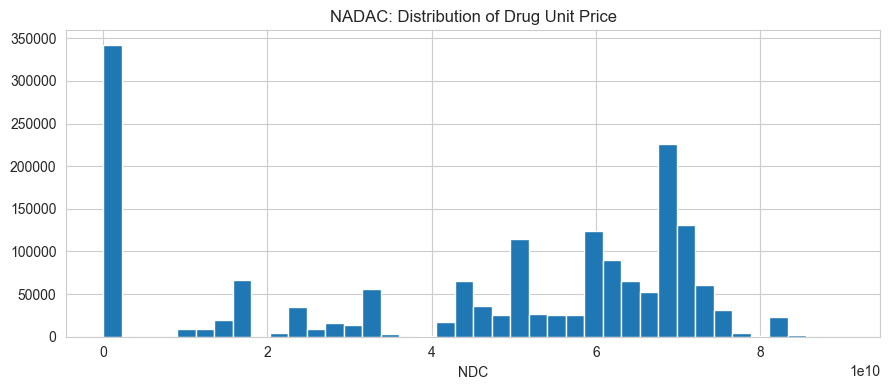

In [294]:
# 1) NADAC: distribution of unit price (nadac_per_unit or first numeric column)
df = dfs.get("nadac")
if df is not None and not df.empty:
    price_col = None
    for c in ["nadac_per_unit", "unit_price", "price", "asp", "wac", "cost"]:
        if c in df.columns:
            price_col = c
            break
    if price_col is None:
        num_cols = df.select_dtypes(include=[np.number]).columns
        price_col = num_cols[0] if len(num_cols) else None
    if price_col is not None:
        fig, ax = plt.subplots(figsize=(9, 4))
        df[price_col].dropna().hist(bins=40, ax=ax, edgecolor="white")
        ax.set_title("NADAC: Distribution of Drug Unit Price")
        ax.set_xlabel(price_col)
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric price column found. Columns:", list(df.columns))
else:
    print("No NADAC data loaded.")

In [295]:
# 2) NADAC: price by drug name (top categories)
df = dfs.get("nadac")
if df is not None and not df.empty:
    name_col = next((c for c in ["drug_name", "brand_name", "proprietary_name", "drug", "labeler_name"] if c in df.columns), None)
    price_col = next((c for c in ["nadac_per_unit", "unit_price", "price"] if c in df.columns), None)
    if not price_col:
        num_cols = df.select_dtypes(include=[np.number]).columns
        price_col = num_cols[0] if len(num_cols) else None
    if name_col and price_col:
        top_drugs = df[name_col].value_counts().head(12).index
        plot_df = df[df[name_col].isin(top_drugs)]
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.boxplot(data=plot_df, x=name_col, y=price_col, ax=ax)
        ax.tick_params(axis="x", rotation=45)
        ax.set_title("NADAC: Unit Price by Drug (top drugs)")
        plt.tight_layout()
        plt.show()
    else:
        print("Need drug name and price columns. Available:", list(df.columns))
else:
    print("No NADAC data loaded.")

Need drug name and price columns. Available: ['NDC Description', 'NDC', 'NADAC Per Unit', 'Effective Date', 'Pricing Unit', 'Pharmacy Type Indicator', 'OTC', 'Explanation Code', 'Classification for Rate Setting', 'Corresponding Generic Drug NADAC Per Unit', 'Corresponding Generic Drug Effective Date', 'As of Date']


In [296]:
# 3) NADAC: time trend (as_of_date or year/quarter) if available
df = dfs.get("nadac")
if df is not None and not df.empty:
    time_col = next((c for c in ["as_of_date", "date", "year", "quarter"] if c in df.columns), None)
    price_col = next((c for c in ["nadac_per_unit", "unit_price", "price"] if c in df.columns), None)
    if not price_col:
        num_cols = df.select_dtypes(include=[np.number]).columns
        price_col = num_cols[0] if len(num_cols) else None
    if time_col and price_col:
        agg = df.groupby(time_col)[price_col].agg(["mean", "median", "count"]).reset_index()
        fig, ax = plt.subplots(figsize=(9, 4))
        ax.plot(agg[time_col].astype(str), agg["mean"], marker="o", label="Mean price")
        ax.plot(agg[time_col].astype(str), agg["median"], marker="s", label="Median price")
        ax.set_title("NADAC: Average Drug Price Over Time")
        ax.set_xlabel(time_col)
        ax.set_ylabel(price_col)
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No date column for time trend. Columns:", list(df.columns))
else:
    print("No NADAC data loaded.")

No date column for time trend. Columns: ['NDC Description', 'NDC', 'NADAC Per Unit', 'Effective Date', 'Pricing Unit', 'Pharmacy Type Indicator', 'OTC', 'Explanation Code', 'Classification for Rate Setting', 'Corresponding Generic Drug NADAC Per Unit', 'Corresponding Generic Drug Effective Date', 'As of Date']


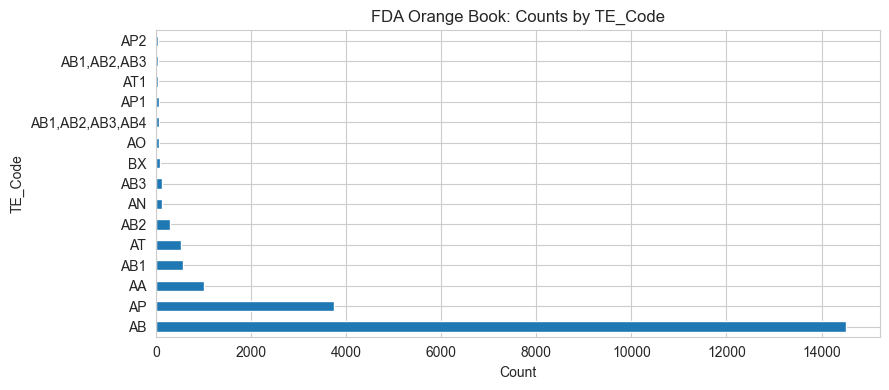

In [297]:
# 4) FDA Orange Book: therapeutic equivalence (TE) code counts
df = dfs.get("orange_book")
if df is not None and not df.empty:
    code_col = next((c for c in ["TE_Code", "te_code", "Appl_Type", "Ingredient"] if c in df.columns), None)
    if not code_col:
        code_col = df.columns[0] if len(df.columns) else None
    if code_col:
        counts = df[code_col].value_counts().head(15)
        fig, ax = plt.subplots(figsize=(9, 4))
        counts.plot(kind="barh", ax=ax)
        ax.set_title("FDA Orange Book: Counts by " + code_col)
        ax.set_xlabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print("Orange Book columns:", list(df.columns))
else:
    print("No FDA Orange Book data loaded.")

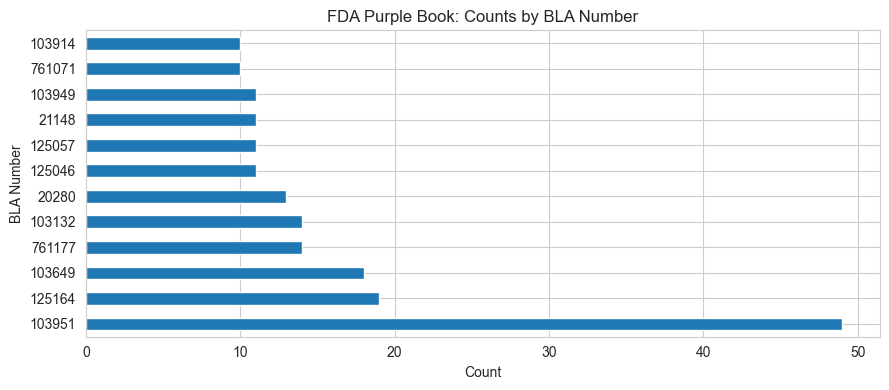

In [298]:
# 5) FDA Purple Book: biosimilar / interchangeable counts (if column exists)
df = dfs.get("purple_book")
if df is not None and not df.empty:
    cat_col = next((c for c in ["Biosimilar", "Interchangeable", "BLA Number", "Proper Name"] if c in df.columns), None)
    if not cat_col:
        cat_col = df.columns[0] if len(df.columns) else None
    if cat_col:
        counts = df[cat_col].value_counts().head(12)
        fig, ax = plt.subplots(figsize=(9, 4))
        counts.plot(kind="barh", ax=ax)
        ax.set_title("FDA Purple Book: Counts by " + cat_col)
        ax.set_xlabel("Count")
        plt.tight_layout()
        plt.show()
    else:
        print("Purple Book columns:", list(df.columns))
else:
    print("No FDA Purple Book data loaded.")

/var/folders/qy/34xjb6gd4yz7dhkb4j33kk000000gn/T/ipykernel_13066/1728499974.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


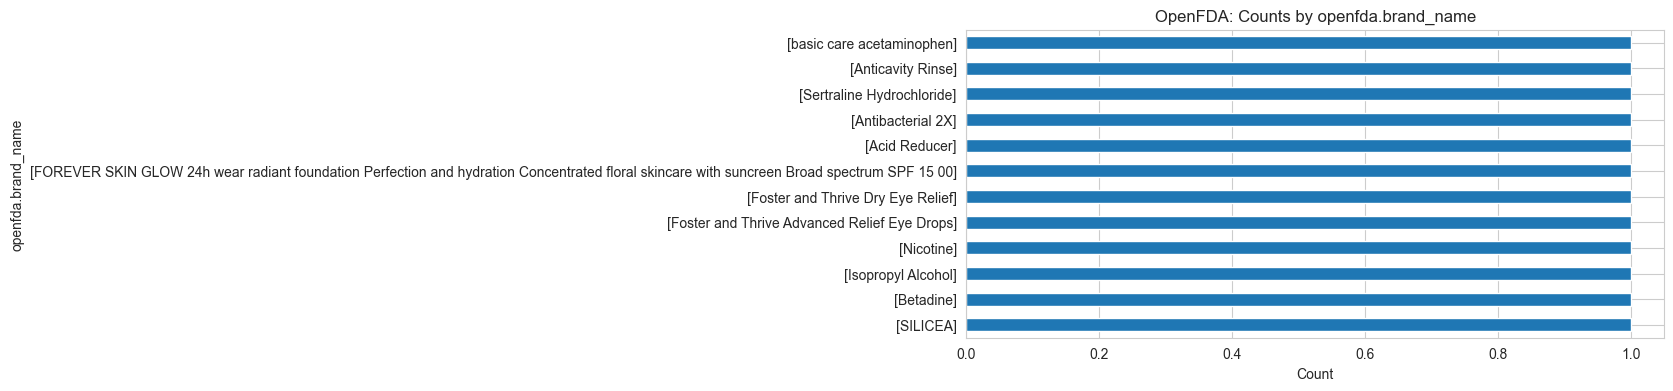

In [299]:
# 6) OpenFDA: brand or substance counts (flattened columns may have dots)
df = dfs.get("openfda")
if df is not None and not df.empty:
    name_col = next((c for c in ["openfda.brand_name", "openfda.substance_name", "brand_name", "substance_name"] if c in df.columns), None)
    if not name_col:
        name_col = df.columns[0] if len(df.columns) else None
    if name_col:
        counts = df[name_col].dropna().value_counts().head(12)
        if not counts.empty:
            fig, ax = plt.subplots(figsize=(9, 4))
            counts.plot(kind="barh", ax=ax)
            ax.set_title("OpenFDA: Counts by " + name_col)
            ax.set_xlabel("Count")
            plt.tight_layout()
            plt.show()
        else:
            print("OpenFDA: no non-null values in", name_col)
    else:
        print("OpenFDA columns:", list(df.columns))
else:
    print("No OpenFDA data loaded.")

In [300]:
# Summary: the four data sources (which is which)
source_labels = {
    "nadac": "1) NADAC (National Average Drug Acquisition Cost)",
    "orange_book": "2) FDA Orange Book — products",
    "orange_book_patent": "2) FDA Orange Book — patent",
    "orange_book_exclusivity": "2) FDA Orange Book — exclusivity",
    "purple_book": "3) FDA Purple Book (Biological Products)",
    "openfda": "4) OpenFDA (API)",
}
for key in ["nadac", "orange_book", "orange_book_patent", "orange_book_exclusivity", "purple_book", "openfda"]:
    df = dfs.get(key)
    label = source_labels.get(key, key)
    if df is not None and not df.empty:
        print(f"{label}: {df.shape[0]} rows × {df.shape[1]} cols")
        print(f"  Columns: {list(df.columns)[:8]}{'...' if len(df.columns) > 8 else ''}")
    else:
        print(f"{label}: (empty or not loaded)")

1) NADAC (National Average Drug Acquisition Cost): 1730427 rows × 12 cols
  Columns: ['NDC Description', 'NDC', 'NADAC Per Unit', 'Effective Date', 'Pricing Unit', 'Pharmacy Type Indicator', 'OTC', 'Explanation Code']...
2) FDA Orange Book — products: 47588 rows × 14 cols
  Columns: ['Ingredient', 'DF;Route', 'Trade_Name', 'Applicant', 'Strength', 'Appl_Type', 'Appl_No', 'Product_No']...
2) FDA Orange Book — patent: 21177 rows × 10 cols
  Columns: ['Appl_Type', 'Appl_No', 'Product_No', 'Patent_No', 'Patent_Expire_Date_Text', 'Drug_Substance_Flag', 'Drug_Product_Flag', 'Patent_Use_Code']...
2) FDA Orange Book — exclusivity: 2483 rows × 5 cols
  Columns: ['Appl_Type', 'Appl_No', 'Product_No', 'Exclusivity_Code', 'Exclusivity_Date']
3) FDA Purple Book (Biological Products): 2190 rows × 25 cols
  Columns: ['N/R/U', 'Applicant', 'BLA Number', 'Proprietary Name', 'Proper Name', 'BLA Type', 'Strength', 'Dosage Form']...
4) OpenFDA (API): 100 rows × 113 cols
  Columns: ['effective_time', 'inac

---
## Normalization utilities

Helpers for canonical NDC (11-digit) and application numbers used across NADAC, OpenFDA, Orange Book, and Purple Book.

In [301]:
import re

def clean_ndc(x):
    """Strip whitespace; keep only digits and hyphens."""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    s = str(x).strip()
    return "".join(c for c in s if c in "0123456789-")

def ndc10_to_ndc11(ndc10: str):
    """
    Convert 10-digit NDC (with or without hyphens) to 11-digit (5-4-2) format.
    If already 11 digits, return as-is (digits only). Otherwise return None if ambiguous/invalid.
    """
    raw = clean_ndc(ndc10)
    digits_only = raw.replace("-", "")
    if len(digits_only) == 11:
        return digits_only
    if len(digits_only) != 10:
        return None
    # 10 digits: segment as 5-4-2 (labeler-product-package)
    if "-" in raw:
        parts = [p for p in raw.split("-") if p]
        if len(parts) == 3:
            a, b, c = parts
            return a.zfill(5) + b.zfill(4) + c.zfill(2)
        if len(parts) == 2:
            a, b = parts
            if len(a) <= 5 and len(b) <= 5:
                # assume 4-4-2 or 5-3-2
                if len(a) == 4 and len(b) == 4:
                    return a.zfill(5) + b[:4].zfill(4) + b[4:].zfill(2) if len(b) >= 6 else None
                return a.zfill(5) + b.zfill(4) + "00"  # package default
        return None
    # no hyphens: 10 digits -> 5-4-2
    return digits_only[:5].zfill(5) + digits_only[5:9].zfill(4) + digits_only[9:].zfill(2)

def extract_ndc_from_description(text):
    """If NADAC only has 'NDC Description', try to extract an NDC (10 or 11 digit) from the text."""
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return None
    s = str(text)
    # Match 11 digits or 10 digits (optionally with hyphens)
    m = re.search(r"\b(\d{5}-?\d{4}-?\d{2}|\d{11}|\d{10})\b", s)
    if m:
        return clean_ndc(m.group(1))
    return None

def normalize_application_number(appl_type, appl_no):
    """Orange Book: build application_number_norm like 'NDA' + zero-padded Appl_No. Appl_Type: N=NDA, A=ANDA."""
    if pd.isna(appl_no) and pd.isna(appl_type):
        return None
    t = str(appl_type).strip().upper() if appl_type is not None and not pd.isna(appl_type) else "NDA"
    n = str(int(appl_no)).strip() if appl_no is not None and not pd.isna(appl_no) else ""
    if not n:
        return None
    prefix = "NDA" if t == "N" else "ANDA"
    return prefix + n.zfill(6)

def normalize_bla_number(bla):
    """Purple Book: normalize BLA to 'BLA' + zero-padded number. Return (normalized, raw)."""
    if bla is None or (isinstance(bla, float) and pd.isna(bla)):
        return None, None
    s = str(bla).strip()
    digits = "".join(c for c in s if c.isdigit())
    if not digits:
        return None, s
    return "BLA" + digits.zfill(6), s

# Quick sanity checks
assert ndc10_to_ndc11("0006-3941-32") == "00006394132"
assert ndc10_to_ndc11("70000047501") == "70000047501"
assert normalize_application_number("N", 205613) == "NDA205613"
assert normalize_bla_number(125525) == ("BLA125525", "125525")
print("Normalization utilities loaded.")

Normalization utilities loaded.


---
## OpenFDA client (notebook version)

In-notebook functions to call `/drug/ndc.json` with caching, retries, and pagination. Used to build the NDC ↔ application_number crosswalk.

In [302]:
# OpenFDA NDC client: openfda_get (cached GET with retries), fetch_openfda_ndc_by_ndc_list, load_openfda_ndc_from_local
import json
import hashlib
import time

def openfda_get(url, params, cache_path=None, api_key=None, max_retries=3):
    """
    GET OpenFDA URL with optional api_key, retries + exponential backoff, and local JSON cache.
    cache_path: if set, use file path keyed by hash of (url, params). Cache dir: pharma_data/openfda_cache.
    """
    params = dict(params or {})
    if api_key:
        params["api_key"] = api_key
    cache_dir = DATA_DIR / "openfda_cache"
    if cache_path is None:
        key = hashlib.sha256((url + json.dumps(params, sort_keys=True)).encode()).hexdigest()[:16]
        cache_path = cache_dir / f"ndc_{key}.json"
    cache_path = Path(cache_path)
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    if cache_path.exists():
        with open(cache_path) as f:
            return json.load(f)
    for attempt in range(max_retries):
        try:
            r = requests.get(url, params=params, timeout=45)
            r.raise_for_status()
            data = r.json()
            with open(cache_path, "w") as f:
                json.dump(data, f, indent=2)
            return data
        except requests.exceptions.HTTPError as e:
            if e.response is not None and e.response.status_code == 404:
                empty = {"results": []}
                with open(cache_path, "w") as f:
                    json.dump(empty, f, indent=2)
                print("OpenFDA NDC endpoint returned 404. See https://open.fda.gov/apis/drug/ for current NDC API.")
                return empty
            if attempt == max_retries - 1:
                raise
            time.sleep(2 ** attempt)
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            time.sleep(2 ** attempt)
    return None

def fetch_openfda_ndc_by_ndc_list(ndc10_or_11_list, cache_dir=None, api_key=None):
    """
    Query OpenFDA /drug/ndc.json per NDC. Uses search=package_ndc:\"...\" (one NDC per request)
    to avoid URL length limits that can cause 404. See https://open.fda.gov/apis/drug/ndc/how-to-use-the-endpoint/
    Returns DataFrame: package_ndc, package_ndc11, product_ndc, application_number, generic_name, brand_name.
    """
    if not ndc10_or_11_list:
        return pd.DataFrame()
    cache_dir = Path(cache_dir or DATA_DIR / "openfda_cache")
    cache_dir.mkdir(parents=True, exist_ok=True)
    def to_search_ndc(ndc):
        s = clean_ndc(ndc).replace("-", "")
        if len(s) == 11:
            return f"{s[:5]}-{s[5:9]}-{s[9:]}"
        if len(s) == 10:
            return f"{s[:5]}-{s[5:9]}-{s[9:]}"
        return ndc
    # One NDC per request to keep URL short (long query strings often cause 404)
    all_rows = []
    for ndc in ndc10_or_11_list:
        term = to_search_ndc(ndc)
        search_query = f'package_ndc:"{term}"'
        params = {"search": search_query, "limit": OPENFDA_LIMIT}
        cache_key = hashlib.sha256((OPENFDA_NDC_URL + json.dumps(params, sort_keys=True)).encode()).hexdigest()[:20]
        cache_path = cache_dir / f"ndc_q_{cache_key}.json"
        try:
            data = openfda_get(OPENFDA_NDC_URL, params, cache_path=cache_path, api_key=api_key or OPENFDA_API_KEY)
        except Exception as e:
            continue
        results = data.get("results", [])
        for rec in results:
            packaging = rec.get("packaging")
            if not isinstance(packaging, list):
                continue
            for pkg in packaging:
                if not isinstance(pkg, dict):
                    continue
                pndc = pkg.get("package_ndc")
                if not pndc:
                    continue
                all_rows.append({
                    "package_ndc": pndc,
                    "package_ndc11": ndc10_to_ndc11(pndc),
                    "product_ndc": rec.get("product_ndc"),
                    "application_number": rec.get("application_number"),
                    "generic_name": rec.get("generic_name"),
                    "brand_name": rec.get("brand_name"),
                })
        time.sleep(0.35)
    return pd.DataFrame(all_rows) if all_rows else pd.DataFrame()

def load_openfda_ndc_from_local(json_path=None):
    """
    Load OpenFDA NDC data from a local JSON file (e.g. full export).
    Explodes packaging[] so one row per package_ndc. Same columns as fetch_openfda_ndc_by_ndc_list.
    """
    path = Path(json_path or DATA_DIR / "openfda_drug_ndc.json")
    if not path.exists():
        return pd.DataFrame()
    with open(path) as f:
        data = json.load(f)
    results = data.get("results", [])
    all_rows = []
    for rec in results:
        packaging = rec.get("packaging")
        if not isinstance(packaging, list):
            continue
        for pkg in packaging:
            if not isinstance(pkg, dict):
                continue
            pndc = pkg.get("package_ndc")
            if not pndc:
                continue
            all_rows.append({
                "package_ndc": pndc,
                "package_ndc11": ndc10_to_ndc11(pndc),
                "product_ndc": rec.get("product_ndc"),
                "application_number": rec.get("application_number"),
                "generic_name": rec.get("generic_name"),
                "brand_name": rec.get("brand_name"),
            })
    return pd.DataFrame(all_rows) if all_rows else pd.DataFrame()

In [303]:
# Smoke test: prefer local openfda_drug_ndc.json; else sample NADAC NDCs and call API
OPENFDA_NDC_LOCAL = DATA_DIR / "openfda_drug_ndc.json"
if OPENFDA_NDC_LOCAL.exists():
    print("Loading OpenFDA NDC from local file:", OPENFDA_NDC_LOCAL.name)
    df_openfda_ndc_sample = load_openfda_ndc_from_local(OPENFDA_NDC_LOCAL)
    print("OpenFDA NDC (from file) shape:", df_openfda_ndc_sample.shape)
    display(df_openfda_ndc_sample.head(10))
else:
    try:
        r = requests.get(OPENFDA_NDC_URL, params={"limit": 5}, timeout=15)
        if r.status_code == 200:
            print("OpenFDA NDC endpoint OK (base URL responds).")
    except Exception as e:
        print("OpenFDA NDC probe:", e)
    if dfs.get("nadac") is not None and not dfs["nadac"].empty:
        ndc_col = "NDC" if "NDC" in dfs["nadac"].columns else next((c for c in dfs["nadac"].columns if "ndc" in c.lower()), None)
        if ndc_col:
            sample_ndcs = dfs["nadac"][ndc_col].dropna().astype(str).unique()[:50]
            sample_ndcs = [clean_ndc(x) for x in sample_ndcs if clean_ndc(x)]
            sample_ndcs = list(dict.fromkeys([x for x in sample_ndcs if len(x.replace("-", "")) in (10, 11)]))[:50]
            print("Sampling", len(sample_ndcs), "NADAC NDCs for OpenFDA NDC fetch...")
            df_openfda_ndc_sample = fetch_openfda_ndc_by_ndc_list(sample_ndcs)
            print("OpenFDA NDC sample shape:", df_openfda_ndc_sample.shape)
            display(df_openfda_ndc_sample.head(10))
        else:
            df_openfda_ndc_sample = pd.DataFrame()
    else:
        df_openfda_ndc_sample = pd.DataFrame()
        print("NADAC not loaded; no local file. Place openfda_drug_ndc.json in pharma_data/ or run API.")

Loading OpenFDA NDC from local file: openfda_drug_ndc.json
OpenFDA NDC (from file) shape: (244341, 6)


,package_ndc,package_ndc11,product_ndc,application_number,generic_name,brand_name
0,75834-327-01,75834032701,75834-327,ANDA209211,Dexmethylphenidate hydrochloride,Dexmethylphenidate hydrochloride
1,0527-6011-06,00527601106,0527-6011,ANDA214464,fluticasone propionate and salmeterol,Fluticasone Propionate and Salmeterol
2,75854-701-01,75854070101,75854-701,NDA214869,Carbidopa Levodopa,Dhivy
3,75907-022-01,75907002201,75907-022,ANDA073618,Carbidopa and Levodopa,Carbidopa and Levodopa
4,75907-024-48,75907002448,75907-024,ANDA079090,CLONIDINE,Clonidine
5,0527-8106-37,00527810637,0527-8106,ANDA210279,dexmethylphenidate hydrochloride,Dexmethylphenidate Hydrochloride Extended-Release
6,75907-051-01,75907005101,75907-051,ANDA078458,Methylphenidate Hydrochloride,Methylphenidate Hydrochloride (LA)
7,75907-069-01,75907006901,75907-069,ANDA073556,Nortriptyline Hydrochloride,Nortriptyline Hydrochloride
8,75907-069-05,75907006905,75907-069,ANDA073556,Nortriptyline Hydrochloride,Nortriptyline Hydrochloride
9,75907-075-32,75907007532,75907-075,ANDA076225,NORETHINDRONE,ERRIN


---
## Build crosswalk tables

Inspect columns of each source, then build normalized/crosswalk tables and a denormalized master view for exploration.

In [304]:
# Inspect columns of each dataframe (choose columns dynamically)
for name in ["nadac", "orange_book", "purple_book"]:
    df = dfs.get(name)
    if df is not None and not df.empty:
        print(f"{name}: {list(df.columns)}")
    else:
        print(f"{name}: (not loaded)")

nadac: ['NDC Description', 'NDC', 'NADAC Per Unit', 'Effective Date', 'Pricing Unit', 'Pharmacy Type Indicator', 'OTC', 'Explanation Code', 'Classification for Rate Setting', 'Corresponding Generic Drug NADAC Per Unit', 'Corresponding Generic Drug Effective Date', 'As of Date']
orange_book: ['Ingredient', 'DF;Route', 'Trade_Name', 'Applicant', 'Strength', 'Appl_Type', 'Appl_No', 'Product_No', 'TE_Code', 'Approval_Date', 'RLD', 'RS', 'Type', 'Applicant_Full_Name']
purple_book: ['N/R/U', 'Applicant', 'BLA Number', 'Proprietary Name', 'Proper Name', 'BLA Type', 'Strength', 'Dosage Form', 'Route of Administration', 'Product Presentation', 'Marketing Status', 'Licensure', 'Approval Date', 'Ref. Product Proper Name', 'Ref. Product Proprietary Name', 'Supplement Number', 'Submission Type', 'License Number', 'Product Number', 'Center', 'Date of First Licensure', 'Exclusivity Expiration Date', 'First Interchangeable Exclusivity Exp. Date', 'Ref. Product Exclusivity Exp. Date', 'Orphan Exclusivi

In [305]:
# --- df_nadac_norm ---
df_nadac_norm = pd.DataFrame()
if dfs.get("nadac") is not None and not dfs["nadac"].empty:
    nadac = dfs["nadac"].copy()
    ndc_raw_col = next((c for c in ["NDC", "ndc", "NDC Code"] if c in nadac.columns), nadac.columns[0])
    nadac["ndc_raw"] = nadac[ndc_raw_col].astype(str)
    nadac["ndc11"] = nadac["ndc_raw"].apply(ndc10_to_ndc11)
    # Where ndc11 is None, try NDC from description
    miss = nadac["ndc11"].isna()
    if "NDC Description" in nadac.columns:
        nadac.loc[miss, "ndc11"] = nadac.loc[miss, "NDC Description"].apply(lambda t: ndc10_to_ndc11(extract_ndc_from_description(t)) if pd.notna(t) else None)
    price_col = next((c for c in ["NADAC Per Unit", "nadac_per_unit", "unit_price", "price"] if c in nadac.columns), None)
    date_col = next((c for c in ["Effective Date", "effective_date", "As of Date", "date"] if c in nadac.columns), None)
    desc_col = next((c for c in ["NDC Description", "drug_name", "description"] if c in nadac.columns), None)
    keep = ["ndc_raw", "ndc11"]
    if price_col:
        keep.append(price_col)
    if date_col:
        keep.append(date_col)
    if desc_col:
        keep.append(desc_col)
    df_nadac_norm = nadac[[c for c in keep if c in nadac.columns]].copy()
    df_nadac_norm = df_nadac_norm.rename(columns={price_col: "price"} if price_col else {}, errors="ignore")
    if date_col and date_col != "date":
        df_nadac_norm = df_nadac_norm.rename(columns={date_col: "date"}, errors="ignore")
print("df_nadac_norm shape:", df_nadac_norm.shape)
if not df_nadac_norm.empty:
    display(df_nadac_norm.head())

df_nadac_norm shape: (1730427, 5)


,ndc_raw,ndc11,price,date,NDC Description
0,24385005452,24385005452,0.28683,12/18/2024,12HR NASAL DECONGEST ER 120 MG
1,70000047501,70000047501,0.28683,12/18/2024,12HR NASAL DECONGEST ER 120 MG
2,46122038576,46122038576,0.72316,12/18/2024,24H NASAL ALLERGY 55 MCG SPRAY
3,70000036201,70000036201,0.17600,12/18/2024,24HR ALLERGY(LEVOCETIRZN) 5 MG
4,70000036202,70000036202,0.17600,12/18/2024,24HR ALLERGY(LEVOCETIRZN) 5 MG


In [306]:
# --- df_openfda_xwalk: one row per package; add application_number_norm ---
try:
    _sample = df_openfda_ndc_sample
except NameError:
    _sample = pd.DataFrame()
if not _sample.empty:
    df_openfda_xwalk = _sample.copy()
else:
    if dfs.get("nadac") is not None and not dfs["nadac"].empty:
        ndc_col = next((c for c in ["NDC", "ndc"] if c in dfs["nadac"].columns), None)
        if ndc_col:
            sample_ndcs = dfs["nadac"][ndc_col].dropna().astype(str).apply(clean_ndc).unique()[:80]
            sample_ndcs = [x for x in sample_ndcs if x and len(x.replace("-", "")) in (10, 11)][:50]
            df_openfda_xwalk = fetch_openfda_ndc_by_ndc_list(sample_ndcs)
        else:
            df_openfda_xwalk = pd.DataFrame()
    else:
        df_openfda_xwalk = pd.DataFrame()
if not df_openfda_xwalk.empty:
    def norm_appl(s):
        if pd.isna(s):
            return None
        s = str(s).strip().upper()
        if not s:
            return None
        digits = "".join(c for c in s if c.isdigit())
        if not digits:
            return None
        # BLA (biologics) so Purple Book matches; check before ANDA
        if "BLA" in s:
            return "BLA" + digits.zfill(6)
        if "ANDA" in s or s.startswith("A"):
            return "ANDA" + digits.zfill(6)
        return "NDA" + digits.zfill(6)
    df_openfda_xwalk["application_number_norm"] = df_openfda_xwalk["application_number"].apply(norm_appl)
print("df_openfda_xwalk shape:", df_openfda_xwalk.shape)
if not df_openfda_xwalk.empty:
    display(df_openfda_xwalk.head())

df_openfda_xwalk shape: (244341, 7)


,package_ndc,package_ndc11,product_ndc,application_number,generic_name,brand_name,application_number_norm
0,75834-327-01,75834032701,75834-327,ANDA209211,Dexmethylphenidate hydrochloride,Dexmethylphenidate hydrochloride,ANDA209211
1,0527-6011-06,00527601106,0527-6011,ANDA214464,fluticasone propionate and salmeterol,Fluticasone Propionate and Salmeterol,ANDA214464
2,75854-701-01,75854070101,75854-701,NDA214869,Carbidopa Levodopa,Dhivy,NDA214869
3,75907-022-01,75907002201,75907-022,ANDA073618,Carbidopa and Levodopa,Carbidopa and Levodopa,ANDA073618
4,75907-024-48,75907002448,75907-024,ANDA079090,CLONIDINE,Clonidine,ANDA079090


In [307]:
# --- df_orange_norm: application_number_norm from Appl_Type + Appl_No ---
df_orange_norm = pd.DataFrame()
if dfs.get("orange_book") is not None and not dfs["orange_book"].empty:
    ob = dfs["orange_book"].copy()
    at = ob.get("Appl_Type")
    an = ob.get("Appl_No")
    if at is not None and an is not None:
        ob["application_number_norm"] = ob.apply(lambda r: normalize_application_number(r.get("Appl_Type"), r.get("Appl_No")), axis=1)
        df_orange_norm = ob.copy()
        # Keep key columns if present
        for c in ["Trade_Name", "Ingredient", "DF;Route", "Strength", "TE_Code", "Applicant", "RLD", "RS", "Type", "Applicant_Full_Name", "Approval_Date"]:
            if c in df_orange_norm.columns:
                pass  # already in ob
        print("df_orange_norm shape:", df_orange_norm.shape)
        display(df_orange_norm.head())
if df_orange_norm.empty:
    print("df_orange_norm: (empty)")

df_orange_norm shape: (47588, 15)


,Ingredient,DF;Route,Trade_Name,Applicant,Strength,Appl_Type,Appl_No,Product_No,TE_Code,Approval_Date,RLD,RS,Type,Applicant_Full_Name,application_number_norm
0,BUDESONIDE,"AEROSOL, FOAM;RECTAL",BUDESONIDE,PADAGIS ISRAEL,2MG/ACTUATION,A,215328,1,AB,"Apr 12, 2023",No,Yes,RX,PADAGIS ISRAEL PHARMACEUTICALS LTD,ANDA215328
1,BUDESONIDE,"AEROSOL, FOAM;RECTAL",UCERIS,SALIX,2MG/ACTUATION,N,205613,1,AB,"Oct 7, 2014",Yes,No,RX,SALIX PHARMACEUTICALS INC,NDA205613
2,MINOCYCLINE HYDROCHLORIDE,"AEROSOL, FOAM;TOPICAL",AMZEEQ,JOURNEY,EQ 4% BASE,N,212379,1,NaN,"Oct 18, 2019",Yes,Yes,RX,JOURNEY MEDICAL CORP,NDA212379
3,AZELAIC ACID,"AEROSOL, FOAM;TOPICAL",AZELAIC ACID,AUROBINDO PHARMA USA,15%,A,210928,1,NaN,"Oct 7, 2020",No,No,DISCN,AUROBINDO PHARMA USA INC,ANDA210928
4,BETAMETHASONE VALERATE,"AEROSOL, FOAM;TOPICAL",BETAMETHASONE VALERATE,ALEMBIC,0.12%,A,215832,1,AB,"Aug 22, 2024",No,No,RX,ALEMBIC PHARMACEUTICALS LTD,ANDA215832


In [308]:
# --- df_purple_norm: application_number_norm from BLA Number ---
df_purple_norm = pd.DataFrame()
if dfs.get("purple_book") is not None and not dfs["purple_book"].empty:
    pb = dfs["purple_book"].copy()
    bla_col = next((c for c in ["BLA Number", "BLA_Number"] if c in pb.columns), None)
    if bla_col:
        pb["application_number_norm"], pb["bla_raw"] = zip(*pb[bla_col].apply(normalize_bla_number))
        df_purple_norm = pb.copy()
        print("df_purple_norm shape:", df_purple_norm.shape)
        display(df_purple_norm.head())
if df_purple_norm.empty:
    print("df_purple_norm: (empty)")

df_purple_norm shape: (2190, 27)


,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date,application_number_norm,bla_raw
0,U,GlaxoSmithKline Biologicals,125127,"Fluarix, Fluarix Quadrivalent",Influenza Vaccine,351(a),60UG/.5ML,Injection,Intramuscular,Pre-Filled Syringe,...,1617,2,CBER,NaN,NaN,NaN,NaN,NaN,BLA125127,125127
1,U,Sanofi Pasteur Limited,125525,Quadracel,Diphtheria and Tetanus Toxoids and Acellular P...,351(a),0.5ML,Injection,Intramuscular,Single-Dose Vial,...,1726,1,CBER,NaN,NaN,NaN,NaN,NaN,BLA125525,125525
2,U,Sanofi Pasteur Limited,125525,Quadracel,Diphtheria and Tetanus Toxoids and Acellular P...,351(a),0.5ML,Injection,Intramuscular,Pre-Filled Syringe,...,1726,2,CBER,NaN,NaN,NaN,NaN,NaN,BLA125525,125525
3,U,SmartPractice Denmark ApS,125579,"hudquzco rubber panel,rubber panel t.r.u.e. test",Rubber Panel Thin-Layer Rapid Use Epicutaneous...,351(a),PATCH TEST 5 ALLERGEN AND ALLERGEN MIX PATCHES...,Patch,Topical,Blister Pack,...,1888,1,CBER,NaN,NaN,NaN,NaN,NaN,BLA125579,125579
4,U,AstraZeneca AB,125586,Andexxa,"Coagulation Factor Xa (Recombinant), Inactivat...",351(a),100MG,Injection,Intravenous,Single-Dose Vial,...,2059,1,CBER,NaN,NaN,NaN,NaN,3-May-25,BLA125586,125586


In [309]:
# --- df_master: denormalized explorer view (ndc11 -> NADAC latest, openFDA, Orange, Purple) ---
# Start from unique ndc11 in NADAC (with latest price/date per ndc11)
df_master = pd.DataFrame()
if not df_nadac_norm.empty and "ndc11" in df_nadac_norm.columns:
    nadac = df_nadac_norm.dropna(subset=["ndc11"]).copy()
    date_col = "date" if "date" in nadac.columns else next((c for c in nadac.columns if "date" in c.lower()), None)
    if date_col:
        nadac["_parsed_date"] = pd.to_datetime(nadac[date_col], errors="coerce")
        latest = nadac.loc[nadac.groupby("ndc11")["_parsed_date"].idxmax()]
    else:
        latest = nadac.drop_duplicates(subset=["ndc11"], keep="first")
    df_master = latest[["ndc11"]].drop_duplicates()
    if "price" in nadac.columns:
        df_master = df_master.merge(latest[["ndc11", "price"]], on="ndc11", how="left")
    if date_col:
        df_master = df_master.merge(latest[["ndc11", date_col]], on="ndc11", how="left")
    # Join openFDA xwalk
    if not df_openfda_xwalk.empty:
        xw = df_openfda_xwalk[["package_ndc11", "product_ndc", "application_number", "application_number_norm"]].drop_duplicates()
        xw = xw.rename(columns={"package_ndc11": "ndc11"})
        df_master = df_master.merge(xw, on="ndc11", how="left")
    # Ensure we have application_number_norm so Orange/Purple merges don't KeyError when xwalk is empty
    if "application_number_norm" not in df_master.columns:
        df_master["application_number_norm"] = pd.NA
    # Join Orange Book by application_number_norm
    if not df_orange_norm.empty and "application_number_norm" in df_orange_norm.columns:
        ob_cols = ["application_number_norm"] + [c for c in ["Trade_Name", "Ingredient", "DF;Route", "Strength", "TE_Code", "Applicant", "RLD"] if c in df_orange_norm.columns]
        ob_agg = df_orange_norm[ob_cols].drop_duplicates(subset=["application_number_norm"])
        df_master = df_master.merge(ob_agg, on="application_number_norm", how="left", suffixes=("", "_ob"))
    # Join Purple Book by application_number_norm
    if not df_purple_norm.empty and "application_number_norm" in df_purple_norm.columns:
        pb_cols = ["application_number_norm"] + [c for c in ["Applicant", "Proprietary Name", "Proper Name", "Biosimilar", "Interchangeable"] if c in df_purple_norm.columns]
        pb_agg = df_purple_norm[pb_cols].drop_duplicates(subset=["application_number_norm"])
        df_master = df_master.merge(pb_agg, on="application_number_norm", how="left", suffixes=("", "_pb"))
    print("df_master shape:", df_master.shape)
    display(df_master.head(10))
else:
    print("df_master: (empty - need df_nadac_norm with ndc11)")

df_master shape: (27260, 16)


,ndc11,price,date,product_ndc,application_number,application_number_norm,Trade_Name,Ingredient,DF;Route,Strength,TE_Code,Applicant,RLD,Applicant_pb,Proprietary Name,Proper Name
0,10019055303,20.45311,11/19/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10019055304,20.45311,11/19/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10019099101,43.34600,03/19/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10094020501,16.11432,01/21/2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10094020560,16.11432,01/21/2026,10094-205,NDA210833,NDA210833,SYMPAZAN,CLOBAZAM,FILM;ORAL,5MG,NaN,ASSERTIO SPECLTY,Yes,NaN,NaN,NaN
5,10094021001,32.15220,01/21/2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10094021060,32.15220,01/21/2026,10094-210,NDA210833,NDA210833,SYMPAZAN,CLOBAZAM,FILM;ORAL,5MG,NaN,ASSERTIO SPECLTY,Yes,NaN,NaN,NaN
7,10094022001,64.20822,01/21/2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10094022060,64.20822,01/21/2026,10094-220,NDA210833,NDA210833,SYMPAZAN,CLOBAZAM,FILM;ORAL,5MG,NaN,ASSERTIO SPECLTY,Yes,NaN,NaN,NaN
9,10147015001,1.05491,08/20/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## Join quality report

Metrics: % NADAC ndc11 matched to OpenFDA xwalk, % with application_number_norm, % matched to Orange Book, % matched to Purple Book. Plus sample unmatched for debugging.

In [310]:
# Unique NADAC ndc11 (from normalized table)
nadac_ndc11 = set()
if not df_nadac_norm.empty and "ndc11" in df_nadac_norm.columns:
    nadac_ndc11 = set(df_nadac_norm["ndc11"].dropna().astype(str).unique())
n_nadac = len(nadac_ndc11)

# Matched to openFDA xwalk (by package_ndc11)
xwalk_ndc11 = set()
if not df_openfda_xwalk.empty and "package_ndc11" in df_openfda_xwalk.columns:
    xwalk_ndc11 = set(df_openfda_xwalk["package_ndc11"].dropna().astype(str).unique())
matched_xwalk = nadac_ndc11 & xwalk_ndc11
n_matched_xwalk = len(matched_xwalk)

# Of matched, how many have application_number_norm
has_appl = set()
if not df_openfda_xwalk.empty:
    has_appl = set(df_openfda_xwalk.loc[df_openfda_xwalk["application_number_norm"].notna(), "package_ndc11"].dropna().astype(str))
n_has_appl = len(matched_xwalk & has_appl)

# application_number_norm matched to Orange Book
orange_appl = set()
if not df_orange_norm.empty and "application_number_norm" in df_orange_norm.columns:
    orange_appl = set(df_orange_norm["application_number_norm"].dropna().astype(str))
# For NADAC ndc11 we get appl_norm via xwalk
appl_norm_from_nadac = df_openfda_xwalk.set_index("package_ndc11")["application_number_norm"].to_dict() if not df_openfda_xwalk.empty else {}
matched_orange = sum(1 for ndc in matched_xwalk if appl_norm_from_nadac.get(ndc) in orange_appl)

# application_number_norm matched to Purple Book
purple_appl = set()
if not df_purple_norm.empty and "application_number_norm" in df_purple_norm.columns:
    purple_appl = set(df_purple_norm["application_number_norm"].dropna().astype(str))
matched_purple = sum(1 for ndc in matched_xwalk if appl_norm_from_nadac.get(ndc) in purple_appl)

report = pd.DataFrame({
    "Metric": [
        "NADAC rows with ndc11 (unique)",
        "% NADAC ndc11 matched to OpenFDA xwalk",
        "% matched that have application_number_norm",
        "% application_number_norm matched to Orange Book (of matched)",
        "% application_number_norm matched to Purple Book (of matched)",
    ],
    "Value": [
        n_nadac,
        f"{100 * n_matched_xwalk / n_nadac:.2f}%" if n_nadac else "N/A",
        f"{100 * n_has_appl / n_matched_xwalk:.2f}%" if n_matched_xwalk else "N/A",
        f"{100 * matched_orange / n_matched_xwalk:.2f}%" if n_matched_xwalk else "N/A",
        f"{100 * matched_purple / n_matched_xwalk:.2f}%" if n_matched_xwalk else "N/A",
    ],
})
display(report)

# Sample unmatched NADAC ndc11 (for debugging)
unmatched_nadac = nadac_ndc11 - xwalk_ndc11
sample_unmatched = list(unmatched_nadac)[:20]
print("Sample unmatched ndc11 (NADAC not in OpenFDA xwalk):", sample_unmatched)
if not df_nadac_norm.empty:
    unmasked = df_nadac_norm[df_nadac_norm["ndc11"].astype(str).isin(sample_unmatched)]
    display(unmasked.head(10))

,Metric,Value
0,NADAC rows with ndc11 (unique),27260
1,% NADAC ndc11 matched to OpenFDA xwalk,85.10%
2,% matched that have application_number_norm,98.58%
3,% application_number_norm matched to Orange Bo...,93.54%
4,% application_number_norm matched to Purple Bo...,0.56%


Sample unmatched ndc11 (NADAC not in OpenFDA xwalk): ['49884021252', '60687035895', '60687052311', '70677016901', '59923071014', '62011009601', '60687059011', '60687085811', '70677104601', '43598070601', '60687080611', '53746019301', '68084014911', '13668059380', '63323034601', '24658031220', '45963056708', '45802086800', '42385095412', '71093012901']


,ndc_raw,ndc11,price,date,NDC Description
1709,13668059380,13668059380,182.15646,12/18/2024,APREPITANT 125 MG CAPSULE
5391,43598070601,43598070601,0.32544,12/18/2024,CHLORDIAZEPOXIDE-CLIDINIUM CAP
6650,60687035895,60687035895,2.53469,12/18/2024,COLCHICINE 0.6 MG CAPSULE
9026,24658031220,24658031220,0.10670,12/18/2024,DOXYCYCLINE HYCLATE 100 MG TAB
10565,45963056708,45963056708,0.40902,12/18/2024,EZETIMIBE-SIMVASTATIN 10-40 MG
11924,70677104601,70677104601,6.02264,12/18/2024,FT DOCOSANOL 10% CREAM
13594,62011009601,62011009601,0.06530,12/18/2024,HM HYDROCORTISONE 1% CREAM
14091,60687059011,60687059011,0.16926,12/18/2024,HYDROMORPHONE 4 MG TABLET
15936,42385095412,42385095412,0.05122,12/18/2024,LEVETIRACETAM 250 MG TABLET
16999,60687080611,60687080611,0.09339,12/18/2024,LITHIUM CARBONATE 300 MG CAP


**Track results:** Copy the metrics table above into [`data_quality_metrics.md`](data_quality_metrics.md) (add a new `## YYYY-MM-DD` section) to track match rates over time.

---
## Exploration: Query by NDC / Generic substitution / Price anomaly

The explorer uses `query_ndc` to show NADAC history, OpenFDA xwalk, Orange Book TE, and Purple Book for a given NDC, plus generic substitution and price anomaly detection.

Normalized ndc11: 70000047501


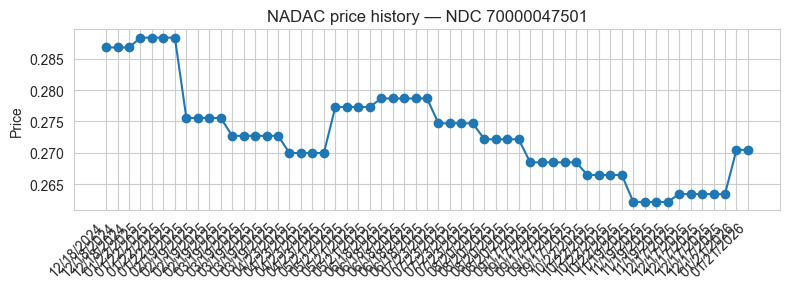

OpenFDA xwalk:


,package_ndc,package_ndc11,product_ndc,application_number,generic_name,brand_name,application_number_norm
20300,70000-0475-1,70000047501,70000-0475,ANDA075153,Pseudoephedrine Hydrochloride,leader 12 hour nasal decongestant,ANDA075153


Orange Book (TE code, etc.):


,Ingredient,DF;Route,Trade_Name,Applicant,Strength,Appl_Type,Appl_No,Product_No,TE_Code,Approval_Date,RLD,RS,Type,Applicant_Full_Name,application_number_norm
26505,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",PSEUDOEPHEDRINE HYDROCHLORIDE,L PERRIGO CO,120MG,A,75153,1,NaN,"Feb 26, 1999",No,Yes,OTC,L PERRIGO CO,ANDA075153


Purple Book:
None


In [311]:
# 1) Query by NDC — set your NDC here (10- or 11-digit, with or without hyphens)
query_ndc = "70000047501"  # example: from NADAC

q_clean = clean_ndc(query_ndc)
q_ndc11 = ndc10_to_ndc11(q_clean)
print("Normalized ndc11:", q_ndc11)

# NADAC history (line chart)
if not df_nadac_norm.empty and q_ndc11:
    hist = df_nadac_norm[df_nadac_norm["ndc11"].astype(str) == str(q_ndc11)].copy()
    if "date" in hist.columns:
        hist["_dt"] = pd.to_datetime(hist["date"], errors="coerce")
        hist = hist.sort_values("_dt")
    if not hist.empty and "price" in hist.columns:
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.plot(range(len(hist)), hist["price"].values, marker="o")
        if "date" in hist.columns:
            ax.set_xticks(range(len(hist)))
            ax.set_xticklabels(hist["date"].astype(str).tolist(), rotation=45, ha="right")
        ax.set_title(f"NADAC price history — NDC {q_ndc11}")
        ax.set_ylabel("Price")
        plt.tight_layout()
        plt.show()
    else:
        display(hist.head())
else:
    print("No NADAC history for this NDC.")

# OpenFDA xwalk info
if not df_openfda_xwalk.empty and q_ndc11:
    xw = df_openfda_xwalk[df_openfda_xwalk["package_ndc11"].astype(str) == str(q_ndc11)]
    print("OpenFDA xwalk:"); display(xw)
else:
    print("No OpenFDA xwalk for this NDC.")

# Orange Book (via application_number_norm)
if not df_openfda_xwalk.empty and q_ndc11:
    appl = df_openfda_xwalk[df_openfda_xwalk["package_ndc11"].astype(str) == str(q_ndc11)]["application_number_norm"].dropna()
    if not appl.empty and not df_orange_norm.empty:
        ob_match = df_orange_norm[df_orange_norm["application_number_norm"].isin(appl)]
        print("Orange Book (TE code, etc.):"); display(ob_match.head())
# Purple Book
if not df_openfda_xwalk.empty and q_ndc11 and not df_purple_norm.empty:
    appl = df_openfda_xwalk[df_openfda_xwalk["package_ndc11"].astype(str) == str(q_ndc11)]["application_number_norm"].dropna()
    if not appl.empty:
        pb_match = df_purple_norm[df_purple_norm["application_number_norm"].isin(appl)]
        print("Purple Book:")
        if not pb_match.empty:
            display(pb_match.head())
        else:
            print("None")

### Generic substitution MVP

Given a brand NDC, find its TE_Code group (or equivalence by Ingredient + DF_Route + Strength), list AB-rated equivalents, and join to NADAC to show prices sorted ascending. **Heuristic:** where Orange Book does not provide a single equivalence key, we group by Ingredient + DF;Route + Strength and filter TE_Code starting with "AB".

In [312]:
# Generic substitution: start from brand_ndc (use query_ndc or set explicitly)
brand_ndc = query_ndc if "query_ndc" in dir() else "70000047501"
b_ndc11 = ndc10_to_ndc11(clean_ndc(brand_ndc))

# Get application_number_norm and Orange Book row(s) for this NDC
brand_appl = None
brand_ob = None
if not df_openfda_xwalk.empty and b_ndc11:
    appl_ser = df_openfda_xwalk[df_openfda_xwalk["package_ndc11"].astype(str) == str(b_ndc11)]["application_number_norm"]
    if not appl_ser.empty:
        brand_appl = appl_ser.iloc[0]
if brand_appl and not df_orange_norm.empty:
    brand_ob = df_orange_norm[df_orange_norm["application_number_norm"] == brand_appl]

# Optional: show why we might have "nothing" (no link or no equivalents with price)
if brand_ob is None or brand_ob.empty:
    if not b_ndc11 or df_openfda_xwalk.empty:
        pass  # will print below
    elif brand_appl is None:
        print(f"Brand NDC {brand_ndc} (ndc11={b_ndc11}) not found in df_openfda_xwalk.")
    else:
        print(f"Brand application {brand_appl} not found in Orange Book (df_orange_norm).")

# Heuristic: same Ingredient + DF;Route + Strength. Prefer AB-rated; if none, show all same product type (e.g. OTC often has no TE_Code).
if brand_ob is not None and not brand_ob.empty:
    ing = brand_ob["Ingredient"].iloc[0] if "Ingredient" in brand_ob.columns else None
    route = brand_ob["DF;Route"].iloc[0] if "DF;Route" in brand_ob.columns else None
    strength = brand_ob["Strength"].iloc[0] if "Strength" in brand_ob.columns else None
    if ing is not None and route is not None and strength is not None:
        # AB-rated only (therapeutic equivalence)
        equiv_ab = df_orange_norm[
            (df_orange_norm["Ingredient"] == ing) &
            (df_orange_norm["DF;Route"] == route) &
            (df_orange_norm["Strength"] == strength) &
            (df_orange_norm["TE_Code"].astype(str).str.startswith("AB", na=False))
        ]
        # All same Ingredient + Route + Strength (for when no AB codes exist, e.g. OTC)
        equiv_any = df_orange_norm[
            (df_orange_norm["Ingredient"] == ing) &
            (df_orange_norm["DF;Route"] == route) &
            (df_orange_norm["Strength"] == strength)
        ]
        equiv = equiv_ab if not equiv_ab.empty else equiv_any
        equiv_appls = equiv["application_number_norm"].dropna().unique()
        if not df_master.empty and "application_number_norm" in df_master.columns:
            equiv_master = df_master[df_master["application_number_norm"].isin(equiv_appls)].copy()
            if "price" in equiv_master.columns:
                equiv_master = equiv_master.dropna(subset=["price"])
                equiv_master["price"] = pd.to_numeric(equiv_master["price"], errors="coerce")
                equiv_master = equiv_master.sort_values("price")
            n_equiv_ob = len(equiv)
            n_equiv_with_price = len(equiv_master)
            if n_equiv_with_price > 0:
                label = "AB-rated equivalents" if not equiv_ab.empty else "Same Ingredient + Route + Strength (no AB codes in Orange Book for this product)"
                print(f"{label}, with NADAC price:")
                display(equiv_master.head(15))
            else:
                if not equiv_ab.empty:
                    print(f"Found {n_equiv_ob} AB-rated equivalent(s) in Orange Book, but none have NADAC price in df_master. Showing Orange Book list:")
                else:
                    print(f"No AB-rated codes for this product in Orange Book (common for OTC). Same Ingredient + Route + Strength ({n_equiv_ob} products). None with NADAC in df_master; showing Orange Book list:")
                display(equiv.head(15))
        else:
            print("Equivalents (Orange Book):"); display(equiv.head(15))
    else:
        print("Could not determine Ingredient/Route/Strength for brand.")
else:
    print("Brand NDC not linked to Orange Book; cannot list equivalents.")

Same Ingredient + Route + Strength (no AB codes in Orange Book for this product), with NADAC price:


,ndc11,price,date,product_ndc,application_number,application_number_norm,Trade_Name,Ingredient,DF;Route,Strength,TE_Code,Applicant,RLD,Applicant_pb,Proprietary Name,Proper Name
2560,24385005452,0.27047,01/21/2026,24385-054,ANDA075153,ANDA075153,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,L PERRIGO CO,No,NaN,NaN,NaN
2561,24385005461,0.27047,01/21/2026,24385-054,ANDA075153,ANDA075153,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,L PERRIGO CO,No,NaN,NaN,NaN
6303,45802010752,0.27047,01/21/2026,45802-107,ANDA075153,ANDA075153,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,L PERRIGO CO,No,NaN,NaN,NaN
9127,51660020421,0.27047,01/21/2026,51660-204,ANDA077442,ANDA077442,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,SUN PHARM INDS LTD,No,NaN,NaN,NaN
9128,51660020469,0.27047,01/21/2026,51660-204,ANDA077442,ANDA077442,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,SUN PHARM INDS LTD,No,NaN,NaN,NaN
9132,51660049221,0.27047,01/21/2026,51660-492,ANDA077442,ANDA077442,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,SUN PHARM INDS LTD,No,NaN,NaN,NaN
22269,70000047501,0.27047,01/21/2026,70000-0475,ANDA075153,ANDA075153,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,L PERRIGO CO,No,NaN,NaN,NaN
22364,70000060101,0.27047,01/21/2026,70000-0601,ANDA077442,ANDA077442,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,SUN PHARM INDS LTD,No,NaN,NaN,NaN
22398,70000065601,0.27047,01/21/2026,70000-0656,ANDA077442,ANDA077442,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,SUN PHARM INDS LTD,No,NaN,NaN,NaN
23082,70677000101,0.27047,01/21/2026,70677-0001,ANDA077442,ANDA077442,PSEUDOEPHEDRINE HYDROCHLORIDE,PSEUDOEPHEDRINE HYDROCHLORIDE,"TABLET, EXTENDED RELEASE;ORAL",120MG,NaN,SUN PHARM INDS LTD,No,NaN,NaN,NaN


### Price anomaly check

For each ndc11, sort by date; if price drops >90% between consecutive timepoints, flag. Show `df_anomalies` and a plot for top anomalies.

Top price anomalies (>90% drop between consecutive dates):


,ndc11,prev_date,curr_date,prev_price,curr_price,pct_drop
18,72205021930,2025-09-17,2025-10-22,13.16018,0.75973,94.227055
12,70069082201,2025-09-24,2025-10-22,13.16018,0.75973,94.227055
16,70954059710,2025-09-17,2025-10-22,13.16018,0.75973,94.227055
14,70748039001,2025-09-17,2025-10-22,13.16018,0.75973,94.227055
6,60505480703,2025-09-17,2025-10-22,13.16018,0.75973,94.227055
8,69097021902,2025-09-17,2025-10-22,13.16018,0.75973,94.227055
1,31722039230,2025-09-17,2025-10-22,13.16018,0.75973,94.227055
10,69238269901,2025-09-17,2025-10-22,13.16018,0.75973,94.227055
17,72205021830,2025-09-17,2025-10-22,12.61141,0.82616,93.449107
15,70954059610,2025-09-17,2025-10-22,12.61141,0.82616,93.449107


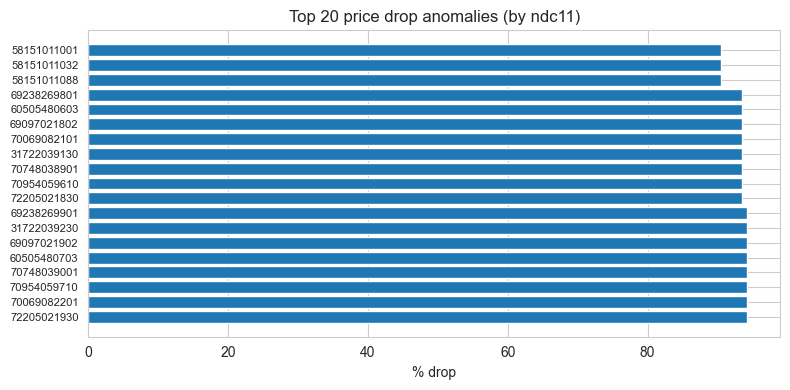

In [313]:
# Price anomaly: drop > 90% between consecutive dates per ndc11
df_anomalies = pd.DataFrame()
if not df_nadac_norm.empty and "ndc11" in df_nadac_norm.columns and "price" in df_nadac_norm.columns:
    date_col = "date" if "date" in df_nadac_norm.columns else None
    if not date_col:
        for c in df_nadac_norm.columns:
            if "date" in c.lower() or "effective" in c.lower():
                date_col = c
                break
    if date_col:
        nadac_sorted = df_nadac_norm.copy()
        nadac_sorted["_dt"] = pd.to_datetime(nadac_sorted[date_col], errors="coerce")
        nadac_sorted = nadac_sorted.dropna(subset=["ndc11", "price", "_dt"])
        nadac_sorted["price"] = pd.to_numeric(nadac_sorted["price"], errors="coerce")
        nadac_sorted = nadac_sorted.sort_values(["ndc11", "_dt"])
        anomalies = []
        for ndc11, grp in nadac_sorted.groupby("ndc11"):
            grp = grp.sort_values("_dt")
            prev_price = None
            prev_date = None
            for _, row in grp.iterrows():
                p = row["price"]
                d = row["_dt"]
                if prev_price is not None and prev_price > 0 and p < prev_price * 0.10:
                    anomalies.append({
                        "ndc11": ndc11,
                        "prev_date": prev_date,
                        "curr_date": d,
                        "prev_price": prev_price,
                        "curr_price": p,
                        "pct_drop": 100 * (1 - p / prev_price),
                    })
                prev_price = p
                prev_date = d
        df_anomalies = pd.DataFrame(anomalies)
        if not df_anomalies.empty:
            df_anomalies = df_anomalies.sort_values("pct_drop", ascending=False)
            print("Top price anomalies (>90% drop between consecutive dates):")
            display(df_anomalies.head(15))
            fig, ax = plt.subplots(figsize=(8, 4))
            top = df_anomalies.head(20)
            ax.barh(range(len(top)), top["pct_drop"].values)
            ax.set_yticks(range(len(top)))
            ax.set_yticklabels(top["ndc11"].astype(str).tolist(), fontsize=8)
            ax.set_xlabel("% drop")
            ax.set_title("Top 20 price drop anomalies (by ndc11)")
            plt.tight_layout()
            plt.show()
        else:
            print("No anomalies (no >90% drop between consecutive dates) found.")
    else:
        print("No date column for anomaly detection.")
else:
    print("NADAC normalized table missing ndc11 or price.")